<h1 style="text-align:center">Fraud Data Analysis</span>

## Assignment Notice
1. Use the fraud dataset
2. Create a Jupyter Notebook file and read the fraud dataset into the file.
3. Freely apply the functions we learned in Pandas and Visualization, and describe and explore the data.
4. Please write down your understanding of the data based on exploring the dataset in the Jupyter Notebook file (use markdown).
- Tip: Be curious about fraud context and data, create as many questions as possible (questions should be meaningful in that context), and try to answer them by exploring data
5. Submit your ipynb file.

## About Data (from Kaggle)
참고: 사기로 감지된 거래는 취소되므로, 이 데이터의 [oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest]을 사용하면 안 됨.

**step** - 현실 세계의 시간 단위 매핑 (1단계=1시간) 총 단계 744(30일 시뮬레이션)\
**type** - CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER.\
**amount** - 거래 금액(현지 통화)\
**nameOrig** - 거래 송신자\
**oldbalanceOrg**, **newbalanceOrig** - 거래 전 초기 잔액, 거래 후 잔액\
**nameDest** - 거래 수신자\
**oldbalanceDest**, **newbalanceDest** - 수신자의 거래 전 초기 잔액, 거래 후 잔액. M(Merchant) 고객 정보는 없음.\
**isFraud** - 시뮬레이션 내 사기 거래. 사기 거래는 통제권이나 고객 계정을 빼앗아 이익을 얻고 다른 계정으로 이체한 다음 시스템에서 현금화하여 자금을 비우는 것을 목표로 함.\
**isFlaggedFraud** - 비즈니스 모델은 한 계정에서 다른 계정으로의 대규모 이체를 제어하고 불법적인 시도를 표시하는 것을 목표로 함. 이 데이터 세트의 불법 시도는 단일 거래에서 200,000 이상의 전송을 시도하는 것.

TIP: 자신만의 가설을 만들어라. 어떤 것이 fraud 데이터일지.\
Fraud 데이터에 영향을 미치는 독립변수는? fraud - non fraud 각각 분석을 해볼 필요도.

# 1. Preparing & Refining Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/2_fraud_ex.csv')

**Q1. 첫 행 또는 마지막 행에 순수 데이터가 아닌 다른 값이 있는가? (상단 헤더, 하단 통계치 등)**\
=> 없음. column 명만 전처리하고 계속 진행 (Org != Orig)

In [3]:
display(df.head(3))
display(df.tail(3))
df.rename(columns={'oldbalanceOrg':'oldbalanceOrig'}, inplace=True)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


## Briefly analyzing data

**Q2. 전체 데이터의 개수, Fraud 데이터의 개수, FlaggedFraud의 개수는 몇 개인가?**\
=> 전체 6362620, Fraud 8213, FlaggedFraud 16개

In [4]:
TOTAL_COUNT = df.shape[0]
FRAUD_COUNT = df[df['isFraud'] == 1].shape[0]
FLAGGED_COUNT = df[df['isFlaggedFraud'] == 1].shape[0]
print(f'TOTAL COUNT:\t{TOTAL_COUNT}\nFRAUD COUNT:\t{FRAUD_COUNT}\nFLAGGED COUNT:\t{FLAGGED_COUNT}')

TOTAL COUNT:	6362620
FRAUD COUNT:	8213
FLAGGED COUNT:	16


**Q3. isFraud == 1, isFlaggedFraud == 1을 동시에 만족하는 항목은 몇 개인가?**\
=> 16개. 여기서 "FlaggedFraud ⊂ Fraud"임을 알 수 있음.

In [5]:
df_fnff = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)]
print('Fraud & FlaggedFraud:', df_fnff.shape[0])
if df[df['isFlaggedFraud'] == 1].equals(df_fnff):
    print('>> Two dataframes are same.')

Fraud & FlaggedFraud: 16
>> Two dataframes are same.


**Q4. Destination이 Merchant인 경우에도 사기 거래가 존재하는가?**\
=> 아님. C또는 M으로 시작하지 않는 거래도 (전체 데이터 중에서) 존재하지 않음.

In [6]:
showFraud = lambda type: df[(df['isFraud'] == 1) & (df['nameDest'].str[0] == type)].shape[0]
print('Fraud C:', showFraud('C'))
print('Fraud M:', showFraud('M'))

if df[(df['nameDest'].str[0] != 'C') & (df['nameDest'].str[0] != 'M')].shape[0] == 0:
    print("There's no data starting with other than C or M.")

Fraud C: 8213
Fraud M: 0
There's no data starting with other than C or M.


***
fraud 거래를 보며 심층적으로 분석해보자.

In [7]:
display(pd.DataFrame(df.groupby(['type', 'isFraud']).count().iloc[:, 0]))
df_fraud = df[df['isFraud'] == 1]
df_nf = df[df['isFraud'] == 0]
display(df_fraud)

step
type     isFraud         
CASH_IN  0        1399284
CASH_OUT 0        2233384
         1           4116
DEBIT    0          41432
PAYMENT  0        2151495
TRANSFER 0         528812
         1           4097

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


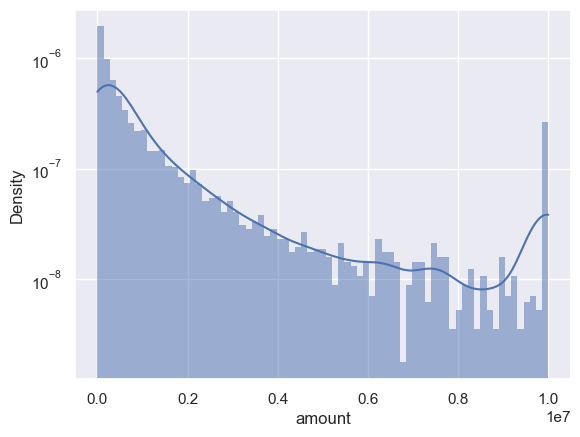

In [8]:
sns.set_theme()
sns.histplot(df_fraud['amount'], kde=True, stat='density', linewidth=0)
plt.yscale('log') # 변화 값이 크게 보이지 않아 log 스케일을 사용

**이로써 사기거래는 다음 조건들을 만족하는 경우에 성립함을 알 수 있음.**

A: type = (CASH_OUT | TRANSFER)\
B: [틀림] ~~amount > 200,000~~ << 실제로는 amount에 상관 없이 Fraud가 발생함\
C: nameDest[0] = 'C' (개인 간 거래)\
D: (이 외 추가적인 조건이 있을 것으로 예상)

이중 A, C의 관계(함수 종속성)를 살펴보자.

In [40]:
df_A = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]
df_C = df[df['nameDest'].str[0] == 'C']

# index 설정을 안 하고 merge할 경우 index가 0부터 시작하도록 초기화됨.
df_in = df_A.reset_index().merge(df_C, how='left').set_index('index')

print('count of A:', len(df_A.index))
print('count of C:', len(df_C.index))
print('count of (A ∩ C):', len(df_in.index))

count of A: 2770409
count of C: 4211125
count of (A ∩ C): 2770409


In [42]:
if df_A.equals(df_in):
    print('A and (A ∩ C) are same')

A and (A ∩ C) are same


따라서 df_A = df_AC ⊂ df_C이므로 A -> C가 성립함.\
즉, **모든 type = (CASH_OUT|TRANSFER)은 nameDest[0] = 'C'이다.**

**Q5. 시간대에 따른 fraud의 분포는 어떠한가? (사기 거래의 시간 분포)**\
=> 각 시간대별로 고르게 분포되어 있음.

<Axes: xlabel='step', ylabel='Density'>

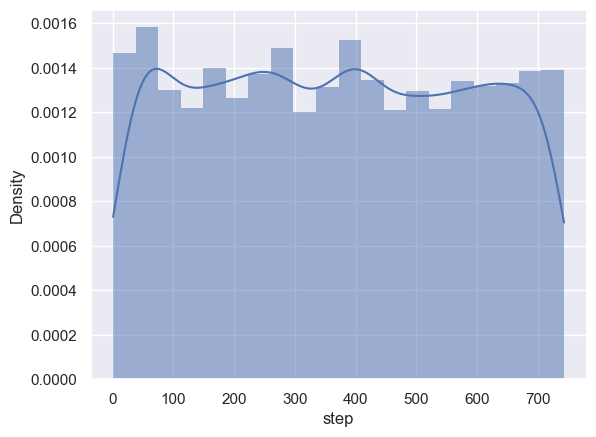

In [36]:
sns.histplot(df_fraud['step'], kde=True, stat='density', linewidth=0)

**Q6. 시간대에 따른 non-fraud의 분포는 어떠한가? (정상 거래의 시간 분포)**\
=> 특정 시간대에는 거래가 많으나 특정 시간대에는 거래가 적음

<Axes: xlabel='step', ylabel='Density'>

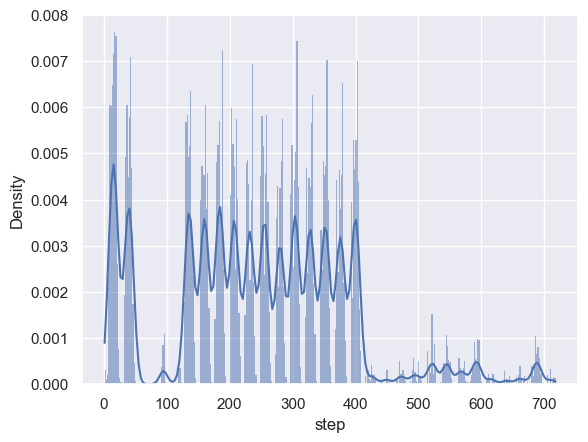

In [34]:
sns.histplot(df_nf['step'], kde=True, stat='density', linewidth=0)

## Correlation Analysis

**fraud 데이터에서,**

amount와 oldbalanceOrg는 강한 정(+)의 상관관계를,\
amount와 newbalanceOrig는 약한 정(+)의 상관관계를 가진다.\
amount와 newbalanceDest는 약한 정(+)의 상관관계를 가진다.

oldbalanceOrg와 newbalanceOrig는 강한 정(+)의 상관관계를,\
oldbalanceOrg와 newBalanceDest는 약한 정(+)의 상관관계를 가진다.

oldbanaceDest와 newbalanceDest는 강한 정(+)의 상관관계를 가진다.

In [16]:
df_corr = df_fraud.drop(columns=['step', 'isFraud', 'isFlaggedFraud'])
df_corr.corr(numeric_only=True).style.set_caption('Correlation of Fraud Data')

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,0.858859,0.338561,-0.007037,0.299403
oldbalanceOrg,0.858859,1.000000,0.767811,-0.013187,0.185974
newbalanceOrig,0.338561,0.767811,1.000000,-0.015964,-0.032040
oldbalanceDest,-0.007037,-0.013187,-0.015964,1.000000,0.880353
newbalanceDest,0.299403,0.185974,-0.032040,0.880353,1.000000


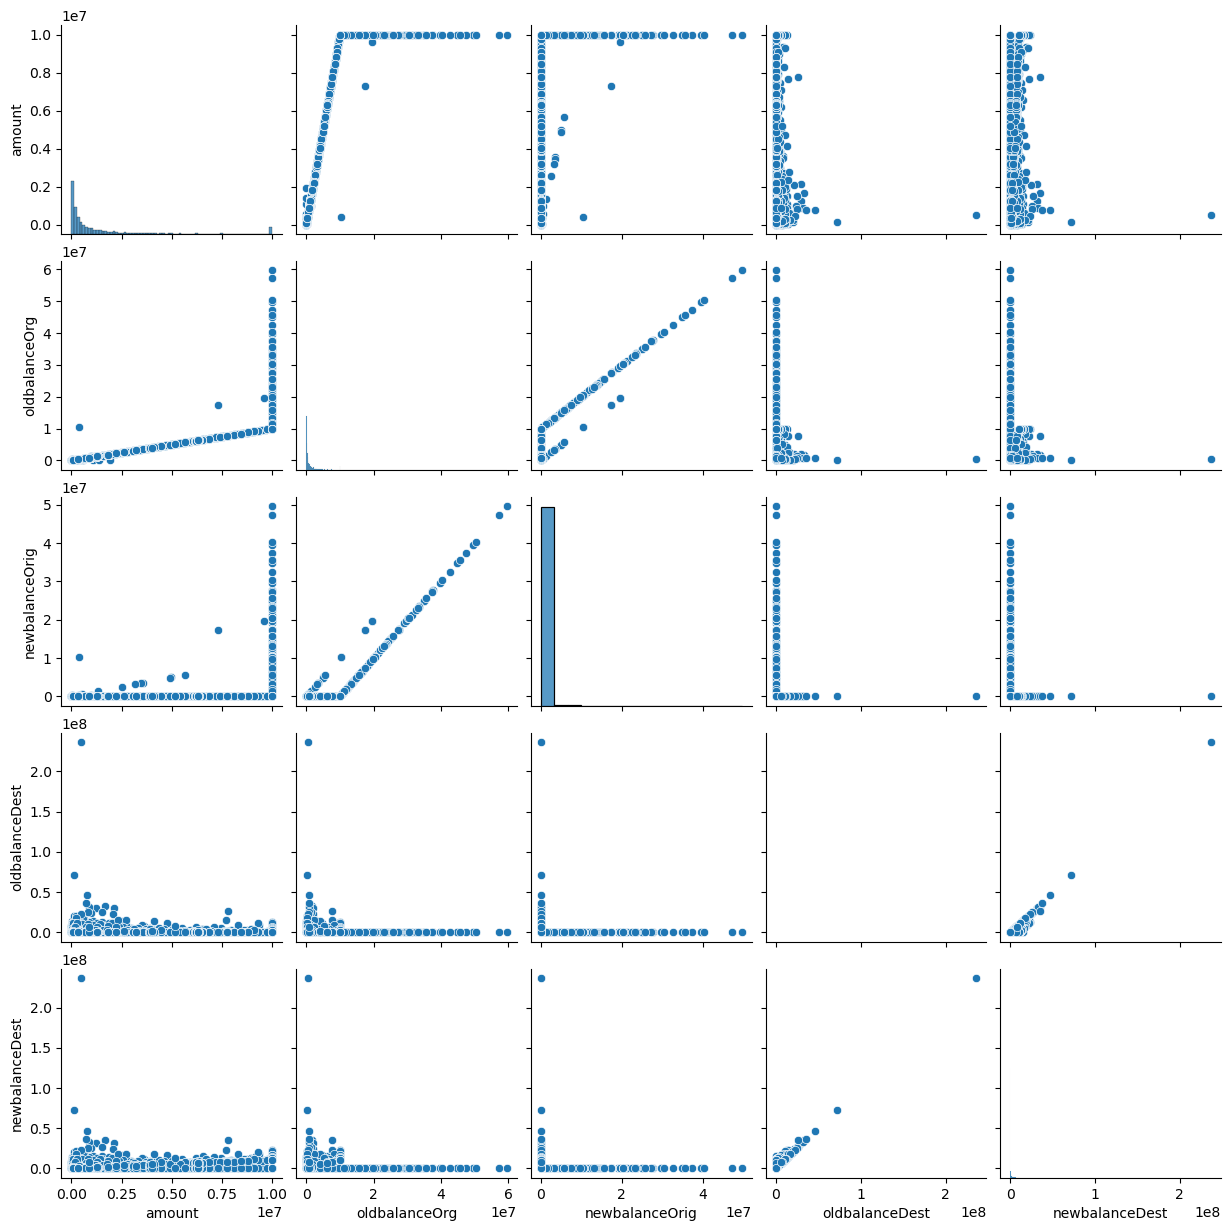

In [20]:
sns.pairplot(df_corr)

상단에 이상치로 추정되는 값이 존재함.

In [13]:
df_nf.drop(columns=['step', 'isFraud', 'isFlaggedFraud'])\
    .corr(numeric_only=True).style.set_caption('Correlation of Non-Fraud Data')

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.009092,-0.008521,0.298774,0.464114
oldbalanceOrg,-0.009092,1.000000,0.999417,0.066433,0.041783
newbalanceOrig,-0.008521,0.999417,1.000000,0.067843,0.041916
oldbalanceDest,0.298774,0.066433,0.067843,1.000000,0.976723
newbalanceDest,0.464114,0.041783,0.041916,0.976723,1.000000


**non-fraud 데이터에서,**

amount와 oldbanaceDest는 약한 정(+)의 상관관계를,\
amount와 newbalanceDest는 어느 정도의 정(+)의 상관관계를 가진다. (fraud와 비슷)


Fraud 데이터에서는....\
~~amount와 oldbalanceOrg는 강한 정(+)의 상관관계를,~~\
~~amount와 newbalanceOrig는 약한 정(+)의 상관관계를 가진다.~~\
~~amount와 newbalanceDest는 약한 정(+)의 상관관계를 가진다.~~

oldbalanceOrg와 newbalanceOrig는 강한 정(+)의 상관관계를 가진다. (fraud와 동일)\
~~oldbalanceOrg와 newbalanceDest는 약한 정(+)의 상관관계를 가진다.~~


oldbanaceDest와 newbalanceDest는 강한 정(+)의 상관관계를 가진다. (fraud와 동일)

**Q7. 상관분석을 통해 추론할 수 있는 내용은 무엇인가?**
1. amount와 oldbalanceOrg의 상관관계가 강한 정의 관계라면 fraud일 확률이 높다. (corr > 0.85)
2. amount와 newbalanceOrig의 상관관계가 정의 관계라면 fraud일 확률이 높다. (corr > 0.33)
3. oldbalanceOrg와 newbalanceDest의 상관관계가 정의 관계라면 fraud일 확률이 높다. (corr > 0.18)
4. amount와 oldbalanceDest의 상관관계가 정의 관계라면 fraud가 **아닐** 확률이 높다. (corr > 0.29)
5. oldbalanceOrg와 newbalanceOrig의 상관관계가 극단적으로 1에 가깝다면 fraud가 **아닐** 확률이 높다. (corr > 0.999)

***
데이터를 골고루 섞어 1%만 추출하고, 다시 분석해보자.

In [9]:
from sklearn.model_selection import train_test_split

_, df_small, _, _ = train_test_split(df, df['isFraud'], test_size = 0.01, stratify=df['isFraud'])
df_small

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5588720,394,TRANSFER,483836.61,C2008433220,10977.00,0.00,C1990013596,314153.61,1012016.24,0,0
1024269,48,CASH_OUT,146521.35,C489415595,0.00,0.00,C750301866,802798.36,949319.71,0,0
490028,19,CASH_OUT,173407.53,C1205989571,0.00,0.00,C1635258370,2192620.89,2666103.76,0,0
904941,43,DEBIT,4621.70,C1434047273,0.00,0.00,C436062906,2725804.99,2730426.70,0,0
1580608,155,PAYMENT,16933.02,C1947173672,39996.00,23062.98,M1712217139,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3518815,259,CASH_IN,27689.02,C175671697,83117.08,110806.10,C309393221,310562.09,282873.07,0,0
4648604,330,CASH_IN,271872.84,C266696959,52020.00,323892.84,C1767014305,246414.50,0.00,0,0
5587001,394,CASH_OUT,99467.84,C1908853977,0.00,0.00,C361408041,1403726.97,1503194.81,0,0
2161311,184,CASH_IN,173497.29,C739518017,105123.00,278620.29,C454761507,2685802.74,2512305.44,0,0


In [10]:
df_small_nf = df_small[df_small['isFraud'] == 0]
df_small_fraud = df_small[df_small['isFraud'] == 1]

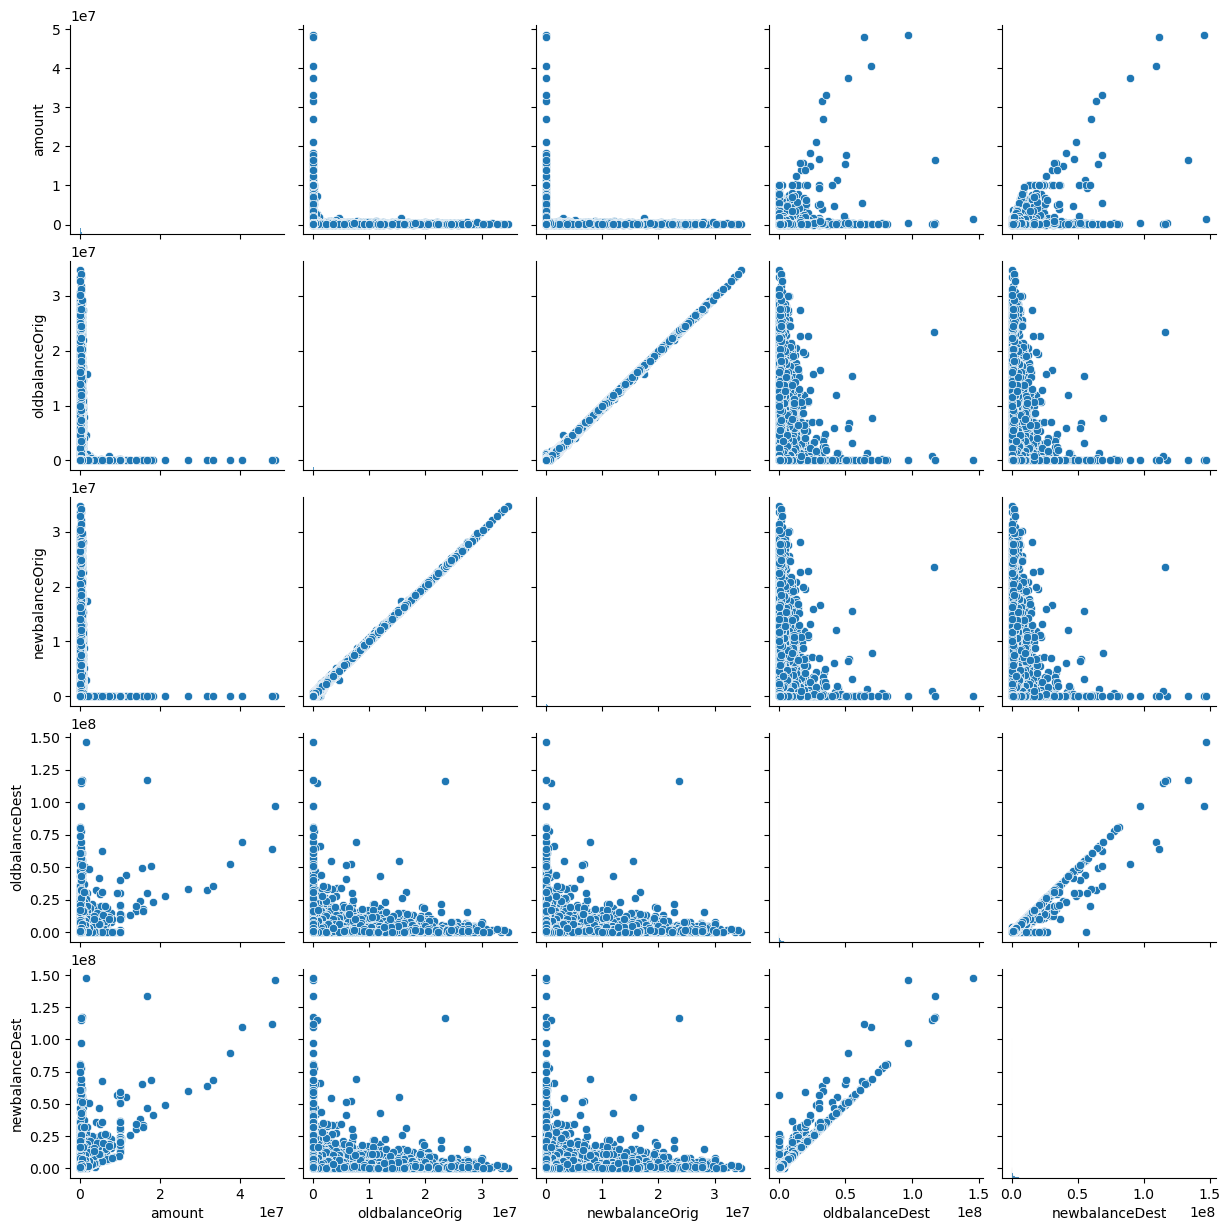

In [52]:
df_corr = df_small_nf.drop(columns=['step', 'isFraud', 'isFlaggedFraud'])
df_corr.corr(numeric_only=True).style.set_caption('Correlation of Non-Fraud Data')
sns.pairplot(df_corr)

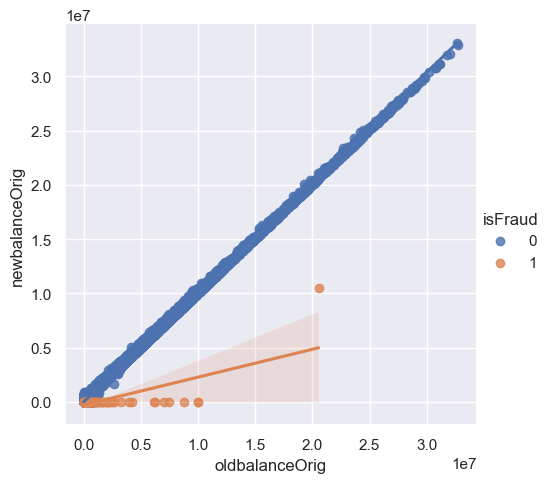

In [23]:
sns.lmplot(x='oldbalanceOrig', y='newbalanceOrig', data=df_small, hue='isFraud')

거의 완벽한 선형관계가 나오는 변수들이 있음. Fraud 데이터에서는 확인할 수 없었던 부분.

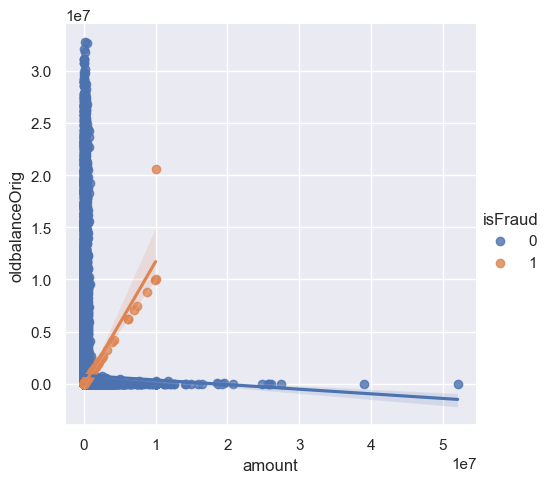

In [24]:
sns.lmplot(x='amount', y='oldbalanceOrig', data=df_small, hue='isFraud')

**Q8. 상관분석 그래프 상에서 Fraud 데이터와 Non Fraud 데이터의 차이가 있는가?**\
=> col 1(amount)에서, Fraud의 경우 오른쪽으로 길게 뻗은 선분이 보이는 반면 Non Fraud의 경우 왼쪽으로 길게 뻗은 선분이 관찰됨.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


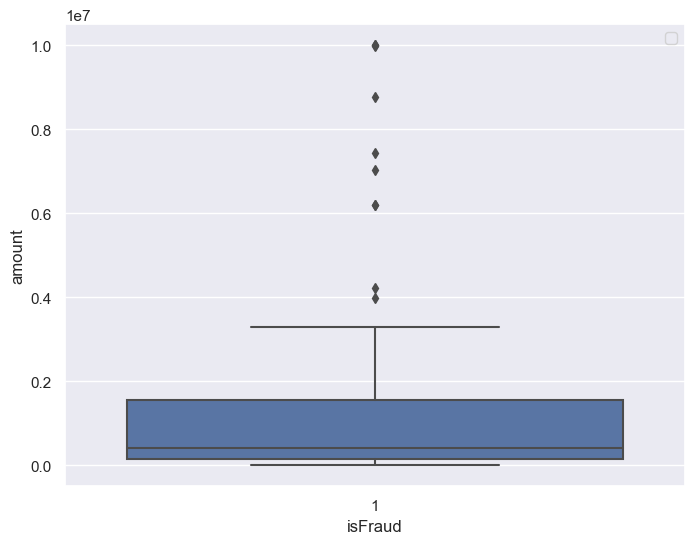

In [20]:
plt.figure(figsize=(8,6))
sns.boxplot(x='isFraud', y='amount', data=df_small_fraud)
plt.legend()

## Conclusion



1. 사기 거래의 type은 CASH_OUT 또는 TRANSFER (=> 이 경우 반드시 nameDest[0] = 'C')
2. 실제 거래의 경우 시간대에 따라 거래량이 크게 차이나나, 사기 거래의 경우 거래량이 일정함.
3. 그 외는 Q7에서 추론한 내용과 동일함.